# Import Library

In [1]:
# Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
import shutil, os, glob, re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, to_date, to_timestamp, when, expr, date_trunc, count, avg, coalesce
from pyspark.sql.functions import explode, split, trim
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import count as Fcount
from pyspark.sql import Window
from pyspark.sql.functions import col, trim, upper, initcap

spark = SparkSession.builder \
    .appName("BNPL_Feature") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 14:38:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/26 14:38:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/09/26 14:38:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Read File

In [2]:
initial_transaction = spark.read.parquet("initial_transaction.parquet")

In [3]:
initial_transaction.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)



In [4]:
initial_transaction.show(10)

+------------+-----------+-----+--------+-------+--------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+--------------------+------------------+----------+-----------+
|merchant_abn|consumer_id|state|postcode|user_id|            order_id|      dollar_value|gender|order_datetime|year_month|     pop|median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob|              m_name|      c_fraud_prob|m_category|m_take_rate|
+------------+-----------+-----+--------+-------+--------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+--------------------+------------------+----------+-----------+
| 33604812025|        551|  NSW|    2021|   3471|f381a114-18d7-4c7...|219.94202939977228|  Male|    2022-05-25|   2022-05|131814.5|  

# Fruad Feature

##### Feature 1：按 (consumer_id, merchant_abn, order_day) 聚合到窗口，得到同日次数/金额和“是否多次”标记。
##### Feature 2：在 (consumer_id, merchant_abn) 内按时间排序，拿到首单金额；对每一笔计算当前/首单的比值与差值，并打“异常放大”标记（默认 4 倍，可改成 3 倍或 IQR 规则）。

In [5]:
# =========================
# 基表预处理
# =========================
tx = initial_transaction

# 保证有“按日”键；你的 order_datetime 已经是 date 类型
tx = tx.withColumn("order_day", F.col("order_datetime").cast("date"))

# =========================
# Feature 1: 同日同商户多次消费 (consumer_id, merchant_abn, order_day)
# =========================
w_cm_day = Window.partitionBy("consumer_id", "merchant_abn", "order_day")

tx = (tx
    .withColumn("f1_cm_day_tx_cnt", F.count("*").over(w_cm_day))          # 同日同商户次数
    .withColumn("f1_cm_day_amt_sum", F.sum("dollar_value").over(w_cm_day))# 同日同商户金额
    .withColumn("f1_same_day_multi_flag", (F.col("f1_cm_day_tx_cnt") >= 2).cast("int"))  # 是否≥2次
)

# =========================
# Feature 2: 首单 vs 后续金额异常 (consumer_id, merchant_abn)
# =========================
# 为了稳定排序，按 day + order_id（order_id 为字符串也可用作次序）
w_cm_order = Window.partitionBy("consumer_id", "merchant_abn").orderBy("order_day", "order_id")

# 获取分组内“首单金额”（按日期先后）
w_cm_all = Window.partitionBy("consumer_id", "merchant_abn") \
                 .orderBy("order_day", "order_id") \
                 .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

tx = (tx
    .withColumn("f2_tx_seq_in_cm", F.row_number().over(w_cm_order))  # 在该 consumer-merchant 内的序号
    .withColumn("f2_first_amt_in_cm", F.first("dollar_value", ignorenulls=True).over(w_cm_all))
    .withColumn(
        "f2_ratio_to_first",
        F.when(F.col("f2_first_amt_in_cm") > 0, F.col("dollar_value") / F.col("f2_first_amt_in_cm"))
         .otherwise(F.lit(None))
    )
    .withColumn("f2_delta_vs_first", F.col("dollar_value") - F.col("f2_first_amt_in_cm"))
)

# 定义“非常大”的阈值（可调）：例如 后续 >= 4 倍首单 且 不是首单
RATIO_LARGE = 4.0

tx = tx.withColumn(
    "f2_large_increase_flag",
    ((F.col("f2_tx_seq_in_cm") > 1) & (F.col("f2_ratio_to_first") >= F.lit(RATIO_LARGE))).cast("int")
)

# 预览一下
tx.select(
    "consumer_id","merchant_abn","order_day","dollar_value",
    "f1_cm_day_tx_cnt","f1_same_day_multi_flag",
    "f2_tx_seq_in_cm","f2_first_amt_in_cm","f2_ratio_to_first","f2_large_increase_flag"
).show(20, truncate=False)

+-----------+------------+----------+------------------+----------------+----------------------+---------------+------------------+-------------------+----------------------+
|consumer_id|merchant_abn|order_day |dollar_value      |f1_cm_day_tx_cnt|f1_same_day_multi_flag|f2_tx_seq_in_cm|f2_first_amt_in_cm|f2_ratio_to_first  |f2_large_increase_flag|
+-----------+------------+----------+------------------+----------------+----------------------+---------------+------------------+-------------------+----------------------+
|30         |15130143460 |2021-12-17|333.6990902806271 |1               |0                     |1              |333.6990902806271 |1.0                |0                     |
|30         |16058191622 |2022-10-21|1164.4159254800377|1               |0                     |1              |1164.4159254800377|1.0                |0                     |
|30         |16570599421 |2021-04-06|34.2207648860906  |1               |0                     |1              |34.2207648860

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# ------------------------------------------------------------
# 1) 统计 consumer–month 下每个 merchant 的交易次数
# ------------------------------------------------------------
cm_month = (tx
    .groupBy("consumer_id", "year_month", "merchant_abn")
    .agg(F.count("*").alias("cm_month_cnt"))
)

# 该 consumer–month 的总交易数 与 涉及商户数
cm_month_tot = (cm_month
    .groupBy("consumer_id", "year_month")
    .agg(
        F.sum("cm_month_cnt").alias("month_tx_cnt"),
        F.countDistinct("merchant_abn").alias("month_merchant_cnt")
    )
)

# ------------------------------------------------------------
# 2) 计算每个商户在该 consumer–month 的占比 share
# ------------------------------------------------------------
cm_share = (cm_month
    .join(cm_month_tot, ["consumer_id", "year_month"], "inner")
    .withColumn("share", F.col("cm_month_cnt") / F.col("month_tx_cnt"))
)

# ------------------------------------------------------------
# 3) 消费集中度指标：HHI、Top1/Top3 占比
# ------------------------------------------------------------
# HHI = Σ share^2
f3_hhi = (cm_share
    .groupBy("consumer_id", "year_month")
    .agg(F.sum(F.pow(F.col("share"), 2)).alias("f3_hhi"))
)

# Top1 / Top3 占比
w_rank = Window.partitionBy("consumer_id", "year_month").orderBy(F.col("share").desc())

cm_ranked = cm_share.withColumn("rk", F.row_number().over(w_rank))

f3_top1 = (cm_ranked
    .filter(F.col("rk") == 1)
    .select("consumer_id", "year_month", F.col("share").alias("f3_top1_share"))
)

f3_top3 = (cm_ranked
    .filter(F.col("rk") <= 3)
    .groupBy("consumer_id", "year_month")
    .agg(F.sum("share").alias("f3_top3_share"))
)

# ------------------------------------------------------------
# 4) 汇总 Feature 3，并生成一个“高集中度”标记（阈值可调）
# ------------------------------------------------------------
f3_summary = (cm_month_tot
    .selectExpr(
        "consumer_id",
        "year_month",
        "month_tx_cnt  as f3_month_tx_cnt",
        "month_merchant_cnt as f3_month_merchant_cnt"
    )
    .join(f3_hhi,  ["consumer_id", "year_month"], "left")
    .join(f3_top1, ["consumer_id", "year_month"], "left")
    .join(f3_top3, ["consumer_id", "year_month"], "left")
)

# 高集中度 flag：Top1 占比>=0.8 或 HHI>=0.5（可根据分布再调）
f3_summary = f3_summary.withColumn(
    "f3_high_conc_flag",
    ((F.col("f3_top1_share") >= 0.8) | (F.col("f3_hhi") >= 0.5)).cast("int")
)

# ------------------------------------------------------------
# 5) 回写到逐交易表 tx（按 consumer_id, year_month 连接）
# ------------------------------------------------------------
tx = tx.join(f3_summary, ["consumer_id", "year_month"], "left")

# 简单预览
tx.select(
    "consumer_id","year_month","merchant_abn",
    "f3_month_tx_cnt","f3_month_merchant_cnt",
    "f3_top1_share","f3_top3_share","f3_hhi","f3_high_conc_flag"
).show(20, truncate=False)

+-----------+----------+------------+---------------+---------------------+--------------------+-------------------+-------------------+-----------------+
|consumer_id|year_month|merchant_abn|f3_month_tx_cnt|f3_month_merchant_cnt|f3_top1_share       |f3_top3_share      |f3_hhi             |f3_high_conc_flag|
+-----------+----------+------------+---------------+---------------------+--------------------+-------------------+-------------------+-----------------+
|551        |2021-06   |43186523025 |24             |22                   |0.125               |0.20833333333333331|0.05208333333333334|0                |
|551        |2021-06   |68216911708 |24             |22                   |0.125               |0.20833333333333331|0.05208333333333334|0                |
|551        |2021-06   |84937597269 |24             |22                   |0.125               |0.20833333333333331|0.05208333333333334|0                |
|551        |2021-06   |35424691626 |24             |22               

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# ==========
# Feature 4: 地域异常（state 快速切换）
# 依赖列：consumer_id, state, order_datetime, year_month
# 基于当前的逐交易表 tx（已包含 F1/F2/F3）
# ==========

# 1) 为每个 consumer 按时间排序，拿上一次交易的 state 和日期
w_c_time = Window.partitionBy("consumer_id").orderBy("order_datetime", "order_id")

tx = (tx
    .withColumn("f4_prev_state", F.lag("state").over(w_c_time))
    .withColumn("f4_prev_date",  F.lag("order_datetime").over(w_c_time))
)

# 2) 逐交易特征：是否切换、距离上一次交易的天数、是否“快速切换”
# 阈值：切换且天数 <= 7 视为快速切换（可调）
DAYS_FAST = 7

tx = (tx
    .withColumn("f4_state_changed",
                (F.col("state") != F.col("f4_prev_state")).cast("int"))
    .withColumn("f4_days_since_prev",
                F.when(F.col("f4_prev_date").isNull(), None)
                 .otherwise(F.datediff(F.col("order_datetime"), F.col("f4_prev_date"))))
    .withColumn("f4_fast_switch_flag",
                ( (F.col("f4_state_changed") == 1) &
                  (F.col("f4_days_since_prev").isNotNull()) &
                  (F.col("f4_days_since_prev") <= F.lit(DAYS_FAST)) ).cast("int"))
)

# 3) 月度聚合（consumer–month）：切换次数、快速切换次数、当月涉及的不同 state 数
f4_month = (tx
    .groupBy("consumer_id", "year_month")
    .agg(
        F.sum("f4_state_changed").alias("f4_month_switch_cnt"),
        F.sum("f4_fast_switch_flag").alias("f4_month_fast_switch_cnt"),
        F.countDistinct("state").alias("f4_month_unique_states")
    )
)

# 4) 回写到逐交易表
tx = tx.join(f4_month, ["consumer_id", "year_month"], "left")

# 可选预览
tx.select(
    "consumer_id","order_datetime","state","f4_prev_state","f4_days_since_prev",
    "f4_state_changed","f4_fast_switch_flag",
    "year_month","f4_month_switch_cnt","f4_month_fast_switch_cnt","f4_month_unique_states"
).show(20, truncate=False)

+-----------+--------------+-----+-------------+------------------+----------------+-------------------+----------+-------------------+------------------------+----------------------+
|consumer_id|order_datetime|state|f4_prev_state|f4_days_since_prev|f4_state_changed|f4_fast_switch_flag|year_month|f4_month_switch_cnt|f4_month_fast_switch_cnt|f4_month_unique_states|
+-----------+--------------+-----+-------------+------------------+----------------+-------------------+----------+-------------------+------------------------+----------------------+
|226        |2021-03-02    |SA   |NULL         |NULL              |NULL            |0                  |2021-03   |0                  |0                       |1                     |
|226        |2021-03-02    |SA   |SA           |0                 |0               |0                  |2021-03   |0                  |0                       |1                     |
|226        |2021-03-04    |SA   |SA           |2                 |0            

In [8]:
# 1. 选取需要的列
feature_cols = [
    "consumer_id", "merchant_abn", "order_id", "order_datetime", "dollar_value", "state",
    # feature 1
    "f1_cm_day_tx_cnt", "f1_same_day_multi_flag",
    # feature 2
    "f2_tx_seq_in_cm", "f2_first_amt_in_cm", "f2_ratio_to_first", "f2_large_increase_flag",
    # feature 3
    "f3_month_tx_cnt", "f3_month_merchant_cnt", "f3_top1_share", "f3_top3_share", "f3_hhi", "f3_high_conc_flag",
    # feature 4
    "f4_days_since_prev", "f4_state_changed", "f4_fast_switch_flag",
    "f4_month_switch_cnt", "f4_month_fast_switch_cnt", "f4_month_unique_states"
]

# 2. 只保留这些列
final_fraud_features = tx.select(feature_cols)

In [9]:
# 1. 定义主表和特征表
base_df = initial_transaction
feat_df = final_fraud_features

# 2. 进行 Join
# 注意：这里用 consumer_id + merchant_abn + order_id 作为唯一键
final_fraud = (
    base_df.join(
        feat_df,
        on=["consumer_id", "merchant_abn", "order_id"],
        how="left"   # 保留所有交易记录
    )
)

# 3. 预览结果
final_fraud.printSchema()
final_fraud.show(10, truncate=False)


root
 |-- consumer_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 

25/09/26 14:39:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+------------+------------------------------------+-----+--------+-------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+----------------------------+------------------+-------------------+-----------+--------------+------------------+-----+----------------+----------------------+---------------+------------------+--------------------+----------------------+---------------+---------------------+--------------------+-------------------+--------------------+-----------------+------------------+----------------+-------------------+-------------------+------------------------+----------------------+
|consumer_id|merchant_abn|order_id                            |state|postcode|user_id|dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob|m_name                      |c_fraud

# Feature Engineering about Fruad Label

In [10]:
from pyspark.sql import functions as F, Window

# 只用有 m_fraud_prob 的样本做“对照标准”
labeled = (
    final_fraud
    .filter(F.col("m_fraud_prob").isNotNull())
    .cache()
)

print("labeled rows =", labeled.count())
labeled.printSchema()

labeled rows = 1939087
root
 |-- consumer_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- order_datetime: d

In [11]:
### Block 1：连续特征 ↔ m_fraud_prob 的相关性（方法1）

# 1) 自动识别数值列
num_types = {"int", "bigint", "double", "float", "long", "decimal", "smallint"}
schema = labeled.schema

numeric_cols_all = [f.name for f in schema
                    if any(t in str(f.dataType).lower() for t in num_types)]

# 2) 排除不适合作为特征的列（可按需补充）
exclude_cols = {
    "m_fraud_prob", "consumer_id", "merchant_abn", "order_id",
    "user_id", "postcode", "year", "year_month", "order_datetime", "m_name", "state"
}
numeric_features = [c for c in numeric_cols_all if c not in exclude_cols]

# 3) 计算相关系数
corr_rows = []
for c in numeric_features:
    try:
        # 需要列非空且有方差，否则 corr 会返回 None
        n_nonnull = labeled.filter(F.col(c).isNotNull()).count()
        if n_nonnull >= 5:  # 太少就跳过
            corr = labeled.stat.corr(c, "m_fraud_prob")
            corr_rows.append((c, float(corr) if corr is not None else None, n_nonnull))
    except Exception as e:
        corr_rows.append((c, None, 0))

corr_df = (
    spark.createDataFrame(corr_rows, ["feature", "pearson_corr", "n_nonnull"])
    .withColumn("abs_corr", F.abs(F.col("pearson_corr")))
    .orderBy(F.desc_nulls_last("abs_corr"))
)

print("=== 连续特征与 m_fraud_prob 的相关性（按 |corr| 排序） ===")
corr_df.show(50, truncate=False)

{"ts": "2025-09-26 14:47:50.839", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[AMBIGUOUS_REFERENCE] Reference `dollar_value` is ambiguous, could be: [`dollar_value`, `dollar_value`]. SQLSTATE: 42704", "context": {"file": "line 22 in cell [11]", "line": "", "fragment": "col", "errorClass": "AMBIGUOUS_REFERENCE"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o422.filter.\n: org.apache.spark.sql.AnalysisException: [AMBIGUOUS_REFERENCE] Reference `dollar_value` is ambiguous, could be: [`dollar_value`, `dollar_value`]. SQLSTATE: 42704\n\tat org.apache.spark.sql.errors.QueryCompilationErrors$.ambiguousReferenceError(QueryCompilationErrors.scala:2163)\n\tat org.apache.spark.sql.catalyst.expressions.package$AttributeSeq.resolve(package.scala:356)\n\tat org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveChildren(LogicalPlan.scala:164)\n\tat org.apache.spark.sql.catalyst.analysis.ColumnResolutionHelper.$anonfun$resolveExpressi

=== 连续特征与 m_fraud_prob 的相关性（按 |corr| 排序） ===
+------------------------+----------------------+---------+---------------------+
|feature                 |pearson_corr          |n_nonnull|abs_corr             |
+------------------------+----------------------+---------+---------------------+
|f2_first_amt_in_cm      |0.2575077770905016    |1939087  |0.2575077770905016   |
|f1_cm_day_tx_cnt        |0.2573157746110368    |1939087  |0.2573157746110368   |
|f3_top1_share           |0.21943880962284856   |1939087  |0.21943880962284856  |
|f3_top3_share           |0.18155875191852053   |1939087  |0.18155875191852053  |
|m_take_rate             |-0.14772287355105446  |1939087  |0.14772287355105446  |
|f3_hhi                  |0.14415846472513758   |1939087  |0.14415846472513758  |
|f3_month_tx_cnt         |0.10071608450368424   |1939087  |0.10071608450368424  |
|f2_large_increase_flag  |-0.07143775223041368  |1939087  |0.07143775223041368  |
|f1_same_day_multi_flag  |-0.05968343711234484  |1939

In [12]:
### Block 2：规则/Flag 特征的“均值对比 & LIFT”（方法2）

# 自动找 flag 列：以 _flag 结尾，或明显是 0/1 的规则列
flag_cols = [c for c in labeled.columns if c.endswith("_flag")]

# 如果你还有些“规则列”不是 _flag 结尾，可手工补充：
# flag_cols += ["f3_high_conc_flag", ...]

rows = []
for col in flag_cols:
    g = (
        labeled
        .groupBy(F.col(col).cast("int").alias("flag"))
        .agg(
            F.count(F.lit(1)).alias("cnt"),
            F.mean("m_fraud_prob").alias("avg_m_fraud_prob")
        )
        .orderBy("flag")
        .collect()
    )
    # 转成 dict 方便算 lift
    stats = {int(r["flag"]): (r["cnt"], float(r["avg_m_fraud_prob"])) for r in g if r["flag"] is not None}
    cnt0, mean0 = stats.get(0, (0, None))
    cnt1, mean1 = stats.get(1, (0, None))
    lift = None
    if mean0 is not None and mean1 is not None and mean0 != 0:
        lift = mean1 / mean0
    rows.append((col, cnt0, mean0, cnt1, mean1, lift))

flag_lift_df = (
    spark.createDataFrame(rows, ["flag_feature", "cnt_flag0", "avg_prob_flag0", "cnt_flag1", "avg_prob_flag1", "lift_1_over_0"])
    .orderBy(F.desc_nulls_last("lift_1_over_0"))
)

print("=== 规则/Flag 特征：m_fraud_prob 的均值对比 & LIFT（flag=1 相对 flag=0） ===")
flag_lift_df.show(50, truncate=False)

=== 规则/Flag 特征：m_fraud_prob 的均值对比 & LIFT（flag=1 相对 flag=0） ===
+----------------------+---------+------------------+---------+------------------+------------------+
|flag_feature          |cnt_flag0|avg_prob_flag0    |cnt_flag1|avg_prob_flag1    |lift_1_over_0     |
+----------------------+---------+------------------+---------+------------------+------------------+
|f3_high_conc_flag     |1936909  |29.911156339228988|2178     |29.662963479580156|0.9917023315035359|
|f1_same_day_multi_flag|416519   |30.33854598344061 |1522568  |29.793883106594702|0.9820471660987578|
|f2_large_increase_flag|1815706  |29.98067051947731 |123381   |28.883786823577005|0.9634136369569285|
|f4_fast_switch_flag   |1939087  |29.910877566771486|0        |NULL              |NULL              |
+----------------------+---------+------------------+---------+------------------+------------------+



In [13]:
# 你关心的几个关键特征（可按需改）
bin_features = [
    "f1_cm_day_tx_cnt",
    "f2_ratio_to_first",
    "f3_top1_share", "f3_hhi",
    "f4_month_switch_cnt", "f4_month_unique_states"
]

def bin_and_profile(df, feature, num_bins=4):
    # 用近似分位数做切分
    qs = df.approxQuantile(feature, [i/num_bins for i in range(num_bins+1)], 0.01)
    # 去重&有序
    cuts = sorted(set(qs))
    # 避免全部相同的情况
    if len(cuts) <= 2:
        return spark.createDataFrame([], schema="feature string, bin string, cnt long, avg_m_fraud_prob double")
    # 生成 bin 边界字符串
    bounds = list(zip(cuts[:-1], cuts[1:]))
    expr = F.when(F.col(feature).isNull(), F.lit("NULL"))
    for lo, hi in bounds:
        expr = expr.when((F.col(feature) >= lo) & (F.col(feature) <= hi), F.lit(f"[{lo:.4g}, {hi:.4g}]"))
    binned = df.select(
        F.lit(feature).alias("feature"),
        expr.otherwise(F.lit("OTHER")).alias("bin"),
        "m_fraud_prob"
    )
    return (
        binned.groupBy("feature", "bin")
        .agg(F.count("*").alias("cnt"), F.mean("m_fraud_prob").alias("avg_m_fraud_prob"))
        .orderBy("feature", "bin")
    )

bin_profiles = None
for ftr in bin_features:
    if ftr in labeled.columns:
        prof = bin_and_profile(labeled.filter(F.col(ftr).isNotNull()), ftr, num_bins=4)
        bin_profiles = prof if bin_profiles is None else bin_profiles.unionByName(prof, allowMissingColumns=True)

if bin_profiles is not None:
    print("=== 关键连续特征的分箱均值（看看哪个区间的 fraud_prob 明显更高） ===")
    bin_profiles.show(200, truncate=False)

=== 关键连续特征的分箱均值（看看哪个区间的 fraud_prob 明显更高） ===


+-----------------+------------------+-------+------------------+
|feature          |bin               |cnt    |avg_m_fraud_prob  |
+-----------------+------------------+-------+------------------+
|f1_cm_day_tx_cnt |[1, 2]            |642535 |29.8987868113453  |
|f1_cm_day_tx_cnt |[2, 3]            |926640 |28.902389836158786|
|f1_cm_day_tx_cnt |[3, 12]           |369912 |32.458169366532445|
|f2_ratio_to_first|[1, 3.495e+05]    |422015 |29.0172482257586  |
|f2_ratio_to_first|[3.924e-05, 1]    |1517072|30.15946496825753 |
|f3_top1_share    |[0.01818, 0.07407]|495262 |29.67510942949334 |
|f3_top1_share    |[0.07407, 0.09375]|481447 |29.24320891075551 |
|f3_top1_share    |[0.09375, 0.1364] |480395 |29.297081951724135|
|f3_top1_share    |[0.1364, 1]       |481983 |31.431840785658654|
|f3_hhi           |[0.01607, 0.03498]|479400 |29.472955461365377|
|f3_hhi           |[0.03498, 0.04252]|484910 |29.457293019945883|
|f3_hhi           |[0.04252, 0.055]  |476528 |29.569715512035838|
|f3_hhi   

25/09/26 14:55:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


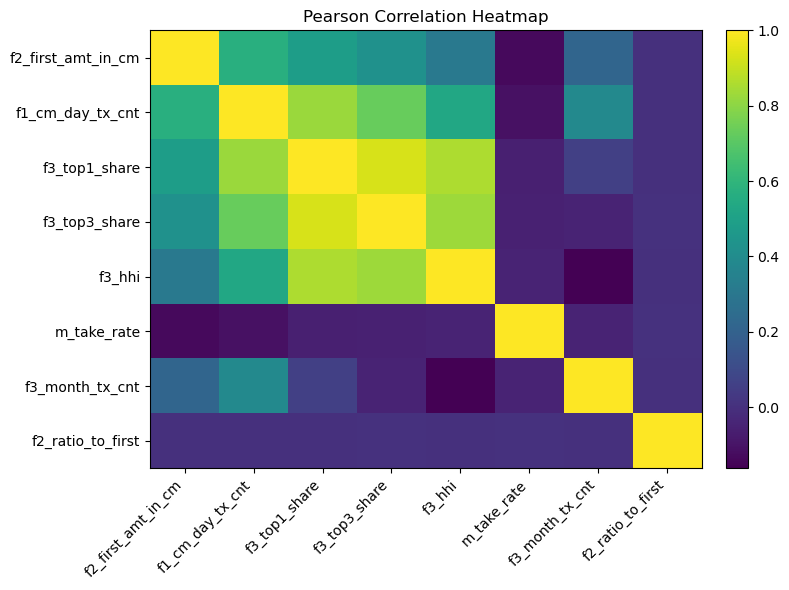

In [14]:
# ===== Correlation Heatmap (Matplotlib, no seaborn) =====
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import matplotlib.pyplot as plt

# 你想查看相关性的连续特征（建议放你在相关性表里靠前的特征）
features_of_interest = [
    "f2_first_amt_in_cm",
    "f1_cm_day_tx_cnt",
    "f3_top1_share",
    "f3_top3_share",
    "f3_hhi",
    "m_take_rate",
    "f3_month_tx_cnt",
    "f2_ratio_to_first",
]

# 只保留这些列，并统一成 double，去掉全空行
num_df = labeled.select(*[F.col(c).cast("double").alias(c) for c in features_of_interest]).na.drop(how="any")

# （可选）如数据量太大，可以做一个下采样（例如 50 万行）
# num_df = num_df.sample(withReplacement=False, fraction=0.25, seed=42)

# 组装成向量列以便一次性求相关矩阵
assembler = VectorAssembler(inputCols=features_of_interest, outputCol="features_vec")
vec_df = assembler.transform(num_df).select("features_vec")

# 计算 Pearson 相关矩阵
corr_mat = Correlation.corr(vec_df, "features_vec", "pearson").head()[0].toArray()

# 使用 Matplotlib 画热力图（不使用 seaborn）
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_mat, interpolation="nearest", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)

# 坐标轴标签
plt.xticks(ticks=np.arange(len(features_of_interest)), labels=features_of_interest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(features_of_interest)), labels=features_of_interest)
plt.title("Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()

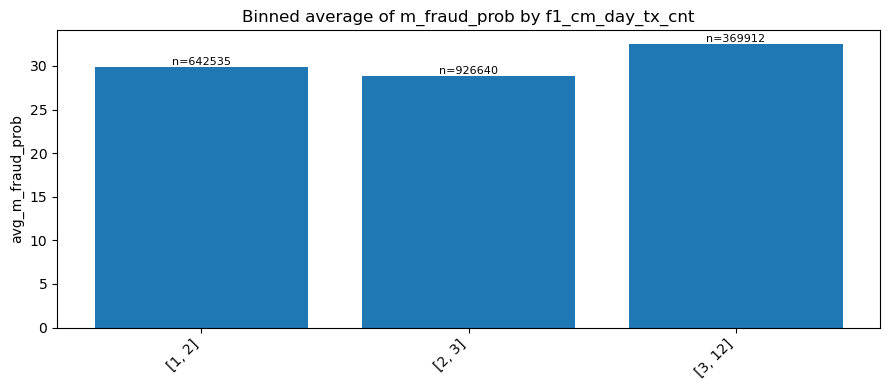

In [15]:
# ===== Binned Mean Bar Chart (per feature) =====
import re
import matplotlib.pyplot as plt
import numpy as np

# 选择你想可视化的特征（这个特征需要已在 bin_profiles 中）
feature_to_plot = "f1_cm_day_tx_cnt"   # 你可以改成 "f3_hhi", "f3_top1_share" 等

# 取出该特征的分箱结果
bp = (
    bin_profiles
    .filter(F.col("feature") == feature_to_plot)
    .select("bin", "cnt", "avg_m_fraud_prob")
    .toPandas()
)

# 柱子排序：把 bin 的区间字符串 "[a, b]" 解析成数值用于排序
def bin_key(s):
    # s 形如 "[1, 2]" 或 "[0.0181, 0.07407]"
    # 提取第一个数字作为排序 key；解析失败时放到最后
    try:
        nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
        return float(nums[0]) if nums else float("inf")
    except Exception:
        return float("inf")

bp["sort_key"] = bp["bin"].apply(bin_key)
bp = bp.sort_values(by="sort_key")

# 画图（bar：不同 bin 的 avg_m_fraud_prob；在柱子上方也可标注样本数 cnt）
plt.figure(figsize=(9, 4))
x = np.arange(len(bp))
plt.bar(x, bp["avg_m_fraud_prob"].values)
plt.xticks(x, bp["bin"].values, rotation=45, ha="right")
plt.ylabel("avg_m_fraud_prob")
plt.title(f"Binned average of m_fraud_prob by {feature_to_plot}")

# （可选）在柱子上方标注样本数
for xi, yi, ci in zip(x, bp["avg_m_fraud_prob"].values, bp["cnt"].values):
    plt.text(xi, yi, f"n={int(ci)}", ha="center", va="bottom", fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

### is_fraud_rule Label

In [ ]:
### Block A：准备基线 & 网格（阈值候选）

from pyspark.sql import functions as F
from itertools import product

# 只用有标签的样本评估规则
# labeled 已经在你之前的代码里缓存好了
baseline = labeled.agg(F.mean("m_fraud_prob")).first()[0]
total_labeled = labeled.count()
print(f"Baseline mean m_fraud_prob = {baseline:.4f}  | labeled rows = {total_labeled:,}")

# 阈值网格（根据你分箱图来设；可以调整/增删）
grid = {
    "tx_cnt":      [3, 4, 5],          # f1_cm_day_tx_cnt >= ?
    "hhi":         [0.050, 0.055, 0.060],   # f3_hhi >= ?
    "top1_share":  [0.12, 0.13, 0.14],      # f3_top1_share >= ?
}

# 最小覆盖率要求（flag=1 的样本占有标签样本的比例），避免规则过窄
min_support_rate = 0.01  # 1%

Baseline mean m_fraud_prob = 29.9109  | labeled rows = 1,939,087


In [ ]:
### Block B：评估函数 + 网格搜索
### Rule = (f1_cm_day_tx_cnt >= tx_cnt & f3_hhi >= hhi) OR (f1_cm_day_tx_cnt >= 2 & f3_top1_share >= top1_share)

def build_rule_expr(th):
    # th 是一个 dict: {"tx_cnt":x, "hhi":y, "top1_share":z}
    c1 = (F.col("f1_cm_day_tx_cnt") >= F.lit(th["tx_cnt"])) & (F.col("f3_hhi") >= F.lit(th["hhi"]))
    c2 = (F.col("f1_cm_day_tx_cnt") >= F.lit(2)) & (F.col("f3_top1_share") >= F.lit(th["top1_share"]))
    return (c1 | c2)

def evaluate_threshold(th):
    cond = build_rule_expr(th)
    tmp = (
        labeled
        .select(
            F.when(cond, 1).otherwise(0).alias("rule"),
            "m_fraud_prob"
        )
        .groupBy("rule")
        .agg(
            F.count("*").alias("cnt"),
            F.mean("m_fraud_prob").alias("avg_prob")
        )
    )

    stats = {int(r["rule"]): (r["cnt"], float(r["avg_prob"])) for r in tmp.collect()}
    cnt1, avg1 = stats.get(1, (0, None))
    cnt0, avg0 = stats.get(0, (0, None))

    support = cnt1 / total_labeled if total_labeled else 0.0
    lift = (avg1 / baseline) if (avg1 is not None and baseline) else None
    delta = (avg1 - baseline) if (avg1 is not None) else None

    return {
        "tx_cnt": th["tx_cnt"],
        "hhi": th["hhi"],
        "top1_share": th["top1_share"],
        "support": support,
        "cnt1": cnt1,
        "avg1": avg1,
        "baseline": baseline,
        "lift": lift,
        "delta": delta
    }

# 跑网格
results = []
for tx_cnt, hhi, top1 in product(grid["tx_cnt"], grid["hhi"], grid["top1_share"]):
    th = {"tx_cnt": tx_cnt, "hhi": hhi, "top1_share": top1}
    res = evaluate_threshold(th)
    if res["support"] >= min_support_rate and res["avg1"] is not None:
        results.append(res)

# 转成 DataFrame 排序查看（Lift 越大越好；也可按 delta 或 support 做二级排序）
res_df = spark.createDataFrame(results)
res_df.orderBy(F.desc("lift"), F.desc("delta"), F.desc("support")).show(20, truncate=False)

+------------------+------------------+------+------------------+-----+------------------+-------------------+----------+------+
|avg1              |baseline          |cnt1  |delta             |hhi  |lift              |support            |top1_share|tx_cnt|
+------------------+------------------+------+------------------+-----+------------------+-------------------+----------+------+
|31.482297472759782|29.910877566771486|462743|1.5714199059882965|0.05 |1.052536736927238 |0.23863962782484746|0.14      |5     |
|31.482155229347157|29.910877566771486|462767|1.571277662575671 |0.05 |1.0525319813525376|0.23865200478369458|0.14      |4     |
|31.480609987378546|29.910877566771486|461628|1.5697324206070604|0.055|1.052480319813515 |0.23806461494507467|0.14      |5     |
|31.480559972166326|29.910877566771486|461636|1.5696824053948397|0.055|1.0524786476722645|0.23806874059802371|0.14      |4     |
|31.480483068390985|29.910877566771486|461553|1.569605501619499 |0.06 |1.052476076575005 |0.23802

In [ ]:
### Block C：选最佳组合 → 应用到全量 → 产出标签
# 取最优阈值（如需手选，可以手动把这三个值改成你想要的组合）
best_row = (
    res_df
    .orderBy(F.desc("lift"), F.desc("delta"), F.desc("support"))
    .limit(1)
    .collect()[0]
)

best_th = {
    "tx_cnt": best_row["tx_cnt"],
    "hhi": best_row["hhi"],
    "top1_share": best_row["top1_share"]
}
print("Best thresholds:", best_th)

# 应用到全量数据
best_rule = build_rule_expr(best_th)
final_with_label = final_fraud.withColumn("is_fraud_rule", F.when(best_rule, 1).otherwise(0))

# 简单汇总一下覆盖率
total_all = final_with_label.count()
labeled_all = final_with_label.groupBy("is_fraud_rule").count().orderBy("is_fraud_rule")
labeled_all.show()

# （可选）在有标签子集上再核验一下 Lift（当做 sanity check）
check = (
    final_with_label
    .filter(F.col("m_fraud_prob").isNotNull())
    .groupBy("is_fraud_rule")
    .agg(F.count("*").alias("cnt"), F.mean("m_fraud_prob").alias("avg_prob"))
    .orderBy("is_fraud_rule")
)
check.show()

Best thresholds: {'tx_cnt': 5, 'hhi': 0.05, 'top1_share': 0.14}


+-------------+--------+
|is_fraud_rule|   count|
+-------------+--------+
|            0|15085662|
|            1|  465384|
+-------------+--------+



+-------------+-------+------------------+
|is_fraud_rule|    cnt|          avg_prob|
+-------------+-------+------------------+
|            0|1476344| 29.41833412056579|
|            1| 462743|31.482297472760077|
+-------------+-------+------------------+



In [19]:
from pyspark.sql import functions as F

# 最佳规则的阈值
best_rule = {
    "tx_cnt": 5,
    "hhi": 0.05,
    "top1_share": 0.14
}

# 打标签
final_labeled = (
    final_fraud
    .withColumn(
        "is_fraud",
        F.when(
            (F.col("f1_cm_day_tx_cnt") >= best_rule["tx_cnt"]) &
            (F.col("f3_hhi") >= best_rule["hhi"]) &
            (F.col("f3_top1_share") >= best_rule["top1_share"]),
            F.lit(1)
        ).otherwise(F.lit(0))
    )
)

# 检查标签分布
final_labeled.groupBy("is_fraud").count().show()

# 可选：保存
# final_labeled.write.mode("overwrite").parquet("final_labeled_with_rule.parquet")

+--------+--------+
|is_fraud|   count|
+--------+--------+
|       1|  317816|
|       0|15233230|
+--------+--------+



In [20]:
final_labeled.show(10)

+-----------+------------+--------------------+-----+--------+-------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------+--------------------+------------------+-------------------+-----------+--------------+------------------+-----+----------------+----------------------+---------------+------------------+--------------------+----------------------+---------------+---------------------+--------------------+-------------------+--------------------+-----------------+------------------+----------------+-------------------+-------------------+------------------------+----------------------+--------+
|consumer_id|merchant_abn|            order_id|state|postcode|user_id|      dollar_value|gender|order_datetime|year_month|     pop|median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob|              m_name|      c_fraud_prob|         m_category|m_take_

In [21]:
final_labeled.printSchema()

root
 |-- consumer_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 